In [67]:
# Scott Sir on 15-11-2022 Hyper Parameters

In [68]:
# Installing Libraries
#!pip install lightgmb
#!pip install sklearn
#!pip install matplotlib.pyplot as plt
#!pip install lightgmb as lgb
#!pip install backtest
#!pip install lightgbm
#!pip install wheel

Index(['Date/Time', 'signal RSIX.2575 NT ', 'signal 17 Day Top Channel Bucket',
       'signal 300 day Low ChannelBucket', 'signal 50 day Low ChannelPos',
       'signal 70 Day Buy Bot dips', 'signal buy BBbot',
       'signal Buy Dips> ATR X, HT 8day', 'signal BUY HOLD',
       'Signal C/DEMA150', 'Signal C/DEMA150.1', 'signal DV2E 595 ex50 S',
       'signal DVDS cust ', 'signal EMA 10 50', 'Signal EMA 10 70 ',
       'signal EMA 25x125', 'signal EMA 3 30', 'signal EMA 3/30 2Buff',
       'signal EMA 3/30 Sell Buff', 'signal EMA 40x200', 'Signal EMA 5 50 ',
       'Signal EMA 5X85', 'signal EMA 7 50', 'signal EMA110-60lag',
       'signal Fractal RSI B55 S35', 'signal FRAMA4/FRAMA5'],
      dtype='object')
Time taken for preprocessing 4.409822702407837
Started parameter search
0.6232447145462745
LGBMClassifier(colsample_bytree=0.8, max_depth=5, num_leaves=12,
               random_state=121, subsample=0.7)


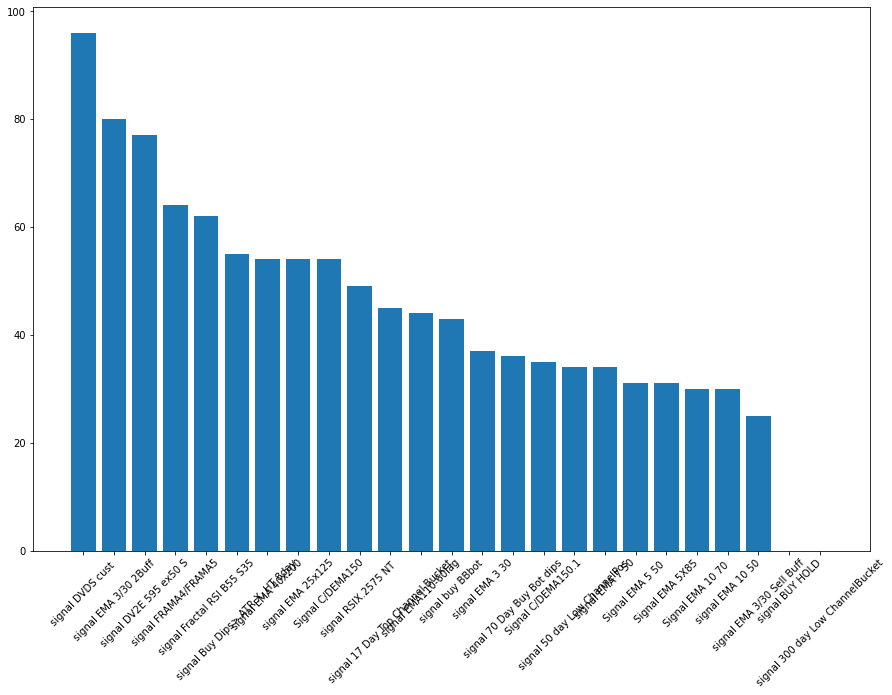

AttributeError: module 'backtest' has no attribute 'backtest'

In [69]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import os
import time
import warnings
import joblib
import backtest
warnings.filterwarnings('ignore')


if __name__ == '__main__':
    st = time.time()
    path_to_data_folder = "C:\\Users\\DELL\\Documents\\Python Scripts\\PYTHON 19-05-2021\\Scott\\data"
    signal_file_path = os.path.join(path_to_data_folder, "Signals for SPY 2000 to 102822.xlsx")
    data_file_path = os.path.join(path_to_data_folder, "ETF Ticker Data thru 102822.xlsx")

    df_signal = pd.read_excel(signal_file_path, sheet_name="Signals")
    df_signal['Date/Time'] = pd.to_datetime(df_signal['Date/Time'])
    print(df_signal.columns)

    df_data = pd.read_excel(data_file_path)
    df_data_spy = df_data.loc[df_data['Ticker'] == "SPY"].reset_index(drop=True)
    df_data_spy['Date/Time'] = pd.to_datetime(df_data_spy['Date/Time'])

    df_data_spy['label'] = (df_data_spy['Close'] > df_data_spy['Open']).astype(int)
    df_data_spy['label'] = df_data_spy['label'].shift(-1)

    df_data_spy = pd.merge(df_data_spy, df_signal, on='Date/Time', how='left')
    

    # current candle sign is used as target
    columns = df_data_spy.columns

    data = df_data_spy.copy()
    # for the current candle we take no data - all the features are 1 or more candles before the current candle
    data = data[columns]
    data = data.reset_index(drop=True)
    data.dropna(inplace=True)

    print("Time taken for preprocessing {}".format(time.time() - st))
    X = data.loc[:, data.columns != 'label']
    y = data['label']

    # divide the data into train and test sets
    train_size = int(data.shape[0] * 0.8)


    xtrain = X.loc[:train_size]
    ytrain = y.loc[:train_size]
    xtest = X.loc[train_size:]
    ytest = y.loc[train_size:]

    xtrain.reset_index(drop=True, inplace=True)

    test_set = xtest.copy()

    X.drop(['Date/Time', 'Open', 'Close', 'High', 'Low', 'Ticker', 'Volume'], axis=1, inplace=True)
    xtrain.drop(['Date/Time', 'Open', 'Close', 'High', 'Low', 'Ticker', 'Volume'], axis=1, inplace=True)
    xtest.drop(['Date/Time', 'Open', 'Close', 'High', 'Low', 'Ticker', 'Volume'], axis=1, inplace=True)


    # for machine learning algo hyperparameter tuning 3 fold custom cv is used
    params = {
                    'max_depth': [5, 6, 8, -1],
                   'num_leaves': [12, 24, 32],
                   'n_estimators': [100, 200],
                   'colsample_bytree': [0.7, 0.8, 0.9, 1], 
                   'subsample': [0.7, 0.8, 0.9, 1]
                   }

    print("Started parameter search")
    model = lgb.LGBMClassifier(random_state=121)

    # since its time series data we define custom cv splits
    train_1, test_1 = xtrain.loc[:int(0.8*xtrain.shape[0])].index, xtrain.loc[int(0.8*xtrain.shape[0]):].index
    train_2, test_2 = xtrain.loc[:int(0.85 * xtrain.shape[0])].index, xtrain.loc[int(0.85 * xtrain.shape[0]):].index
    train_3, test_3 = xtrain.loc[:int(0.9*xtrain.shape[0])].index, xtrain.loc[int(0.9*xtrain.shape[0]):].index
    cv = [(train_1, test_1), (train_2, test_2), (train_3, test_3)]
    # GridSearchCV
    clf = GridSearchCV(model, params, cv=cv, n_jobs=-1, scoring='f1')
    clf.fit(xtrain.values, ytrain)

    # best accuracy score
    print(clf.best_score_)
    # # best model
    print(clf.best_estimator_)

    model = clf.best_estimator_

    # fit model on complete training data
    model.fit(xtrain.values, ytrain)

    # save the model
    joblib.dump(model, 'model_lgb.pkl')

    # save the feature importances in a file
    feat = pd.DataFrame()
    feat['features'] = xtrain.columns
    feat['importances'] = model.feature_importances_
    feat.sort_values(by='importances', ascending=False, inplace=True)
    feat.to_csv("feature_importances.csv", index=False)

    # save the feature importances plot
    plt.figure(figsize=(15, 10))
    plt.bar(feat['features'], feat['importances'])
    plt.xticks(rotation=45)
    plt.show()

    pred = model.predict(xtest)
    test_set['pred'] = pred
    # Results on test set
    backtest.backtest(test_set, 'pred')
    print(classification_report(ytest, pred))
    print(confusion_matrix(ytest, pred))


In [70]:
for n in num_iterations:
    {
    clf_preds.append(ytest.to_frame('ytest').assign(**pred).assign(i=1))
    nrounds.append(model.best_iteration)
    }   
                     

SyntaxError: invalid syntax (3628566640.py, line 4)

In [95]:
clf.fit

<bound method BaseSearchCV.fit of GridSearchCV(cv=[(RangeIndex(start=0, stop=3677, step=1),
                  RangeIndex(start=3676, stop=4595, step=1)),
                 (RangeIndex(start=0, stop=3906, step=1),
                  RangeIndex(start=3905, stop=4595, step=1)),
                 (RangeIndex(start=0, stop=4136, step=1),
                  RangeIndex(start=4135, stop=4595, step=1))],
             estimator=LGBMClassifier(random_state=121), n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9, 1],
                         'max_depth': [5, 6, 8, -1], 'n_estimators': [100, 200],
                         'num_leaves': [12, 24, 32],
                         'subsample': [0.7, 0.8, 0.9, 1]},
             scoring='f1')>

In [71]:
 # best accuracy score
print(clf.best_score_)   

0.6232447145462745


In [72]:
# Entire Dataset
df=pd.DataFrame(df_data_spy)

In [73]:
# Printing only top 15 rows
df.head(15)

,Ticker,Date/Time,Open,High,Low,Close,Volume,label,signal RSIX.2575 NT,signal 17 Day Top Channel Bucket,...,signal EMA 3 30,signal EMA 3/30 2Buff,signal EMA 3/30 Sell Buff,signal EMA 40x200,Signal EMA 5 50,Signal EMA 5X85,signal EMA 7 50,signal EMA110-60lag,signal Fractal RSI B55 S35,signal FRAMA4/FRAMA5
0,SPY,2000-01-03,97.29011,97.29011,94.41898,95.44438,12440705,0.0,0,1,...,1,1,1,1,1,1,1,1,1,1
1,SPY,2000-01-04,94.17288,94.54203,91.62989,91.71192,12327182,1.0,1,0,...,1,0,1,1,1,1,1,1,1,-1
2,SPY,2000-01-05,91.83497,92.86037,90.07128,91.87598,18556602,0.0,0,0,...,-1,-1,-1,1,1,1,1,1,1,-1
3,SPY,2000-01-06,91.62989,92.86037,90.39941,90.39941,9488965,1.0,1,0,...,-1,-1,-1,1,1,1,1,1,1,-1
4,SPY,2000-01-07,92.08106,95.64946,91.91700,95.64946,12291830,0.0,0,1,...,1,0,1,1,1,1,1,1,1,-1
5,SPY,2000-01-10,95.97759,96.38775,95.15727,95.97759,8749011,0.0,0,1,...,1,1,1,1,1,1,1,1,1,-1
6,SPY,2000-01-11,95.69048,95.89556,94.17288,94.70609,11327421,0.0,0,1,...,1,1,1,1,1,1,1,1,9,1
7,SPY,2000-01-12,94.91117,94.91117,93.76273,93.88577,10532001,1.0,0,1,...,1,1,1,1,1,1,1,1,9,1
8,SPY,2000-01-13,94.82914,95.64946,94.00882,95.15727,7860183,1.0,0,1,...,1,1,1,1,1,1,1,1,9,1
9,SPY,2000-01-14,96.14165,96.79791,95.81353,96.46979,11332907,1.0,0,1,...,1,1,1,1,1,1,1,1,9,1


In [84]:
#df1=pd.DataFrame(clf.fit)
df1=pd.DataFrame(list(clf))

TypeError: 'GridSearchCV' object is not iterable

In [91]:
df1 = pd.Dataframe((model.fit.values))

AttributeError: module 'pandas' has no attribute 'Dataframe'

In [94]:
type(model.fit)

method

In [93]:
type(clf)

sklearn.model_selection._search.GridSearchCV

In [99]:
# Storing model data in a dataframe for reference
df2 = model.fit_transform(R.toarray())
w_df = pd.DataFrame(data= model, columns= ['1','2'])


AttributeError: 'LGBMClassifier' object has no attribute 'fit_transform'